# CLV with python

This notebook explains how to perform Association Analysis from customer purchase history data. We are using [lifetimes](https://github.com/CamDavidsonPilon/lifetimes) (for clv calculation).

Source: https://lifetimes.readthedocs.io/en/master/Quickstart.html

In [2]:
from lifetimes.datasets import load_cdnow_summary

data = load_cdnow_summary(index_col=[0])
data.head()

,frequency,recency,T
ID,,,
1,2,30.43,38.86
2,1,1.71,38.86
3,0,0.00,38.86
4,0,0.00,38.86
5,0,0.00,38.86


## Basic Frequency/Recency analysis using the BG/NBD model

In [3]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
bgf

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.78, alpha: 4.41, b: 2.39, r: 0.24>

### Visualizing our Frequency/Recency Matrix

In [4]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

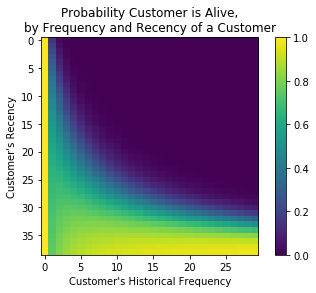

In [5]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

### Ranking customers from best to worst

In [6]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
ID,,,,
509,18,35.14,35.86,0.425132
841,19,34.00,34.14,0.474968
1981,17,28.43,28.86,0.486814
157,29,37.71,38.00,0.662671
1516,26,30.86,31.00,0.710931


### Assessing model fit

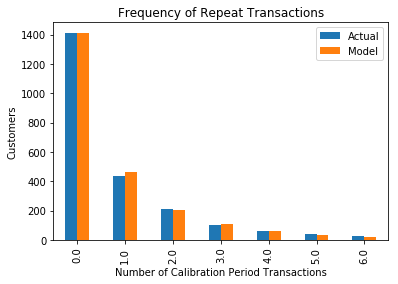

In [7]:
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(bgf)

### Example using transactional datasets

In [8]:
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

transaction_data = load_transaction_data()
print(transaction_data.head())
summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end='2014-12-31')

print(summary.head())
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

                  date  id
0  2014-03-08 00:00:00   0
1  2014-05-21 00:00:00   1
2  2014-03-14 00:00:00   2
3  2014-04-09 00:00:00   2
4  2014-05-21 00:00:00   2
    frequency  recency      T
id                           
0         0.0      0.0  298.0
1         0.0      0.0  224.0
2         6.0    142.0  292.0
3         0.0      0.0  147.0
4         2.0      9.0  183.0


<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 1.85, alpha: 1.86, b: 3.18, r: 0.16>

### More model fitting

In [9]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date',
                                        calibration_period_end='2014-09-01',
                                        observation_period_end='2014-12-31' )   
print(summary_cal_holdout.head())

    frequency_cal  recency_cal  T_cal  frequency_holdout duration_holdout
id                                                                       
0             0.0          0.0  177.0                0.0     <121 * Days>
1             0.0          0.0  103.0                0.0     <121 * Days>
2             6.0        142.0  171.0                0.0     <121 * Days>
3             0.0          0.0   26.0                0.0     <121 * Days>
4             2.0          9.0   62.0                0.0     <121 * Days>


In [10]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

TypeError: ("unsupported operand type(s) for +: 'float' and 'Day'", 'occurred at index 0')

## Customer Predictions

In [11]:
t = 10 #predict purchases in 10 periods
individual = summary.iloc[20]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.057651177192369125

## Customer Probability Histories

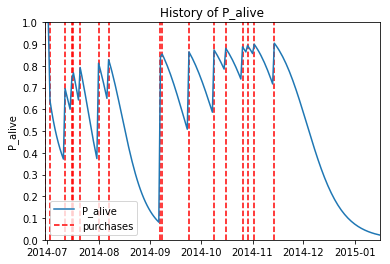

In [12]:
from lifetimes.plotting import plot_history_alive

id = 35
days_since_birth = 200
sp_trans = transaction_data.loc[transaction_data['id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')

## Estimating customer lifetime value using the Gamma-Gamma model

In [13]:
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

print(returning_customers_summary.head())

             frequency  recency      T  monetary_value
customer_id                                           
1                    2    30.43  38.86           22.35
2                    1     1.71  38.86           11.77
6                    7    29.43  38.86           73.74
7                    1     5.00  38.86           11.77
9                    2    35.71  38.86           25.55


### The Gamma-Gamma model and the independence assumption

In [14]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.113884
frequency,0.113884,1.000000


In [15]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>


In [16]:
print(ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).head(10))

customer_id
1     24.658611
2     18.911464
3     35.171010
4     35.171010
5     35.171010
6     71.462859
7     18.911464
8     35.171010
9     27.282404
10    35.171010
dtype: float64


In [17]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).mean(),
    summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 35.25296297447601, Average profit: 35.07855179704017


In [18]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

customer_id
1      140.095970
2       18.943596
3       38.180733
4       38.180733
5       38.180733
6     1003.861947
7       28.109808
8       38.180733
9      167.417912
10      38.180733
Name: clv, dtype: float64
